In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from itertools import combinations 

%matplotlib notebook

In [7]:
def filt(d, fs):
    # 50Hz notch
    b, a = signal.iirnotch(50, 100, fs)
    fl_d1 = signal.lfilter(b, a, d)

    b, a = signal.iirnotch(100, 100, fs)
    fl_d1 = signal.lfilter(b, a, fl_d1)

    b, a = signal.iirnotch(150, 100, fs)
    fl_d1 = signal.lfilter(b, a, fl_d1)

    b, a = signal.iirnotch(200, 100, fs)
    fl_d1 = signal.lfilter(b, a, fl_d1)

    b, a = signal.iirnotch(250, 100, fs)
    fl_d1 = signal.lfilter(b, a, fl_d1)

    # bandpass filter 30 to 200Hz
    b, a = signal.butter(3, [30 / (0.5 * fs), 200 / (0.5 * fs)], btype='band')
    fl_d1 = signal.lfilter(b, a, fl_d1)
    
    return fl_d1


def readFile(fn):
    print("Reading:",fn)
    #Read data
    with open(fn) as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    
    # Clean data
    d = [] # time, CH1, CH2, .., button
    for i in content:
        i = i[1:-1].split(",")
        if len(i) == 11:
            try:
                t1 = [float(_) for _ in i]
                d.append(t1)
            except:
                pass

    # numpyconvert
    d = np.array(d).swapaxes(0, 1)

    # scale and remove dc
    d[0] = d[0] / 10**6
    for i in [1,2,3,4,5,6,7,8]:
        d[i] -= np.mean(d[i])
        
    # stats
    t_d = np.diff(d[0])
    #print(np.mean(t_d)-np.std(t_d), np.mean(t_d)+np.std(t_d))

    # technically wrong, but using anyways
    # please resample properly

    fs = 1/np.mean(t_d)
    
    button = np.convolve(d[-2], [1/1000.0]*1000, "same")
    button[button > 0.1] = 1
    button[button <= 0.1] = 0

    #print(fs)
    
    return np.array([d[0]] + [filt(d[2], fs)] + [filt(x, fs) for x in d[4:9]] + [button])
    
    

In [8]:
def window_rms(a, window_size=2):
    return np.sqrt(sum([a[window_size-i-1:len(a)-i]**2 for i in range(window_size-1)])/window_size)

def feat(x):
    # extract a feature from list x
    return np.max(window_rms(x, 20))
    
def extract_feat(x, f):
    # get button on pos
    xt = np.diff(x[-1])
    st = np.array(np.where(xt == 1))[0]
    
    en = np.array(np.where(xt == -1))[0]
    print(len(st), len(en))
    le = np.array(en - st)
    val = np.array(np.where(le > 500))[0]
    start = st[val]
    end = en[val]
    
    feat = []
    for i in range(len(start)):
        temp = []
        for j in range(6):
            temp.append(f(x[1+j][start[i] - 500:end[i] + 500]))
        feat.append(temp)
    return np.array(feat)

In [9]:
files = ["b_side_" + str(i) + ".txt" for i in range(1,6)]
#files = ["index.txt", "middle.txt", "ring.txt", "little.txt"]
read_dat = [readFile(_) for _ in files]
feats = [extract_feat(_, feat) for _ in read_dat]

Reading: b_side_1.txt
Reading: b_side_2.txt
Reading: b_side_3.txt
Reading: b_side_4.txt
Reading: b_side_5.txt
74 74
76 76
70 70
85 85
87 87


In [10]:
for i in feats:
    print(len(i), i[0])

74 [149.82634004  85.06434562  55.62121767 113.84034455  97.28680384
  97.85935373]
76 [130.95147994  75.42364513  55.58804489 125.09733253  89.83584318
  90.93667867]
70 [316.27151537 206.09957237 106.90339582 189.53677787 322.78596643
  98.80084486]
85 [ 65.75707159 147.50125013 437.48076249 211.41822643 193.83450526
 177.05992017]
87 [159.22534524 103.50023993 112.17030771 134.51999888 178.04192995
  90.51799578]


<IPython.core.display.Javascript object>


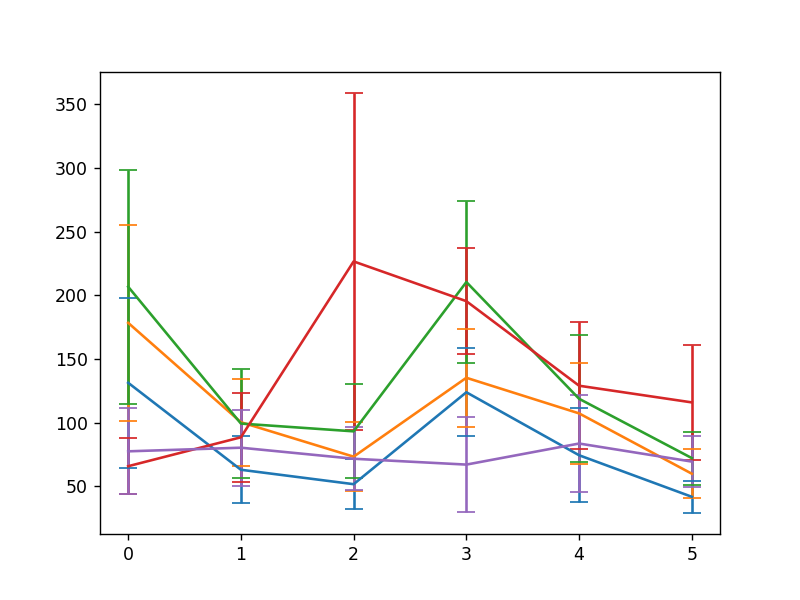

In [11]:
plt.figure()

colors = ["green", "red", "yellow", "blue", "orange"]

for ci,fe in enumerate(feats):
    fe = fe.swapaxes(0,1)
    #print(np.mean(fe, 1), np.std(fe, 1))
    plt.errorbar(range(6), np.mean(fe, 1), np.std(fe, 1), capsize=5)
    
    #for i in range(len(fe)):
    #    plt.plot(range(6), fe[i], "*", color = colors[ci])

plt.show()

In [12]:
def getAccuracy(X, y, r = 0.5, repeat = 1000): #r is test train split 0.5 => equal division
    train_acc_arr, test_acc_arr = [], []
    for _ in range(repeat):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=r)

        clf = SVC(gamma='auto')
        clf.fit(X_train, y_train)

        res = clf.predict(X_train) - y_train
        train_acc = len(np.where(res == 0)[0])*100/len(res)

        res = clf.predict(X_test) - y_test
        test_acc = len(np.where(res == 0)[0])*100/len(res)
        
        train_acc_arr.append(train_acc)
        test_acc_arr.append(test_acc)
    return (np.mean(train_acc_arr), np.mean(test_acc_arr))

In [13]:
def getXy(feats, channels, ratio_i = None):
    X, y = [], []
    for ci,fe in enumerate(feats):
        for i in range(len(fe)):
            y.append(ci)
            
            fep = []
            for chi in channels:
                 fep.append(fe[i][chi])
            if not ratio_i is None:
                div = fep.pop(ratio_i)
            else:
                div = 1.0
            X.append(np.array(fep)/div)
    return X,y

In [14]:
dat = []
for chn in range(1, 7):
    tdat = []
    for chs in list(combinations([0,1,2,3,4,5], chn)):
        for chir in range(len(chs)):
            if len(chs) == 1: chir = None
            tdat.append([chs, chir, getAccuracy(*getXy(feats, chs, chir), r = 0.2)])
            print(tdat[-1])
    dat.append(tdat)

[(0,), None, (76.78210862619808, 34.05949367088608)]
[(1,), None, (60.76230031948882, 26.905063291139243)]
[(2,), None, (66.91948881789136, 39.308860759493676)]
[(3,), None, (76.32651757188498, 45.515189873417725)]
[(4,), None, (64.29329073482428, 28.0)]
[(5,), None, (61.3961661341853, 39.43291139240507)]
[(0, 1), 0, (45.86038338658147, 40.92151898734177)]
[(0, 1), 1, (46.67124600638977, 43.35316455696202)]
[(0, 2), 0, (56.168370607028756, 53.34936708860759)]
[(0, 2), 1, (60.24856230031949, 57.188607594936705)]
[(0, 3), 0, (48.00063897763578, 46.14556962025317)]
[(0, 3), 1, (49.90063897763578, 48.81645569620253)]
[(0, 4), 0, (44.953674121405754, 40.79620253164557)]
[(0, 4), 1, (46.5332268370607, 41.8873417721519)]
[(0, 5), 0, (51.50255591054313, 48.42025316455696)]
[(0, 5), 1, (53.621086261980835, 50.04430379746835)]
[(1, 2), 0, (42.45399361022364, 39.91392405063291)]
[(1, 2), 1, (42.51565495207668, 40.593670886075955)]
[(1, 3), 0, (46.89936102236422, 42.77721518987342)]
[(1, 3), 1, (4

[(1, 3, 4, 5), 1, (57.93929712460064, 54.5253164556962)]
[(1, 3, 4, 5), 2, (61.27444089456869, 58.268354430379745)]
[(1, 3, 4, 5), 3, (63.48690095846646, 59.25696202531645)]
[(2, 3, 4, 5), 0, (64.44313099041533, 59.573417721518986)]
[(2, 3, 4, 5), 1, (57.06166134185303, 53.12911392405063)]
[(2, 3, 4, 5), 2, (61.873162939297124, 58.811392405063295)]
[(2, 3, 4, 5), 3, (62.912140575079874, 59.015189873417725)]
[(0, 1, 2, 3, 4), 0, (68.77220447284344, 63.18227848101265)]
[(0, 1, 2, 3, 4), 1, (70.61405750798723, 65.09493670886076)]
[(0, 1, 2, 3, 4), 2, (73.66102236421723, 69.3493670886076)]
[(0, 1, 2, 3, 4), 3, (68.5153354632588, 64.92278481012657)]
[(0, 1, 2, 3, 4), 4, (70.28977635782748, 66.71012658227848)]
[(0, 1, 2, 3, 5), 0, (70.75303514376998, 65.25569620253165)]
[(0, 1, 2, 3, 5), 1, (71.98626198083066, 67.42278481012657)]
[(0, 1, 2, 3, 5), 2, (75.7108626198083, 72.27341772151898)]
[(0, 1, 2, 3, 5), 3, (69.23482428115015, 65.68354430379746)]
[(0, 1, 2, 3, 5), 4, (75.84952076677317, 71

In [15]:
Xx, Yy = [], []
M_X = []
for ci, i in enumerate(dat):
    MxX, MxV = None, None
    for j in i:
        Xx.append(ci+1)
        Yy.append(j[2][1])
        if MxV is None or MxV < j[2][1]:
            MxV = j[2][1]
            MxX = j
    M_X.append(MxX[2][1])
    print(MxX)
print(M_X)

[(3,), None, (76.32651757188498, 45.515189873417725)]
[(0, 2), 1, (60.24856230031949, 57.188607594936705)]
[(0, 3, 5), 2, (72.01214057507987, 68.28987341772151)]
[(0, 1, 2, 3), 2, (73.6738019169329, 70.17088607594935)]
[(0, 1, 2, 3, 5), 2, (75.7108626198083, 72.27341772151898)]
[(0, 1, 2, 3, 4, 5), 2, (75.36485623003195, 71.20886075949366)]
[45.515189873417725, 57.188607594936705, 68.28987341772151, 70.17088607594935, 72.27341772151898, 71.20886075949366]


<IPython.core.display.Javascript object>


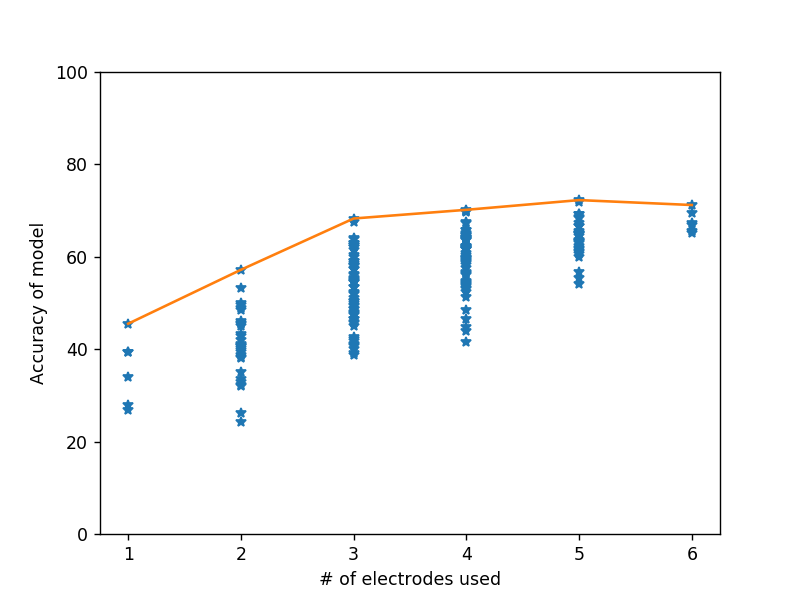

In [16]:
plt.figure()
plt.plot(Xx, Yy, "*")
plt.plot(range(1,7), M_X, "-")
plt.xlabel("# of electrodes used")
plt.ylabel("Accuracy of model")
plt.ylim([0,100])
plt.show()